In [17]:
import pandas as pd
import numpy as np
import os, re, json
import matplotlib.pyplot as plt
%matplotlib inline

PATH2RAW = './experiment_2'
EXPERIMENT = 'session_5-6'

## 1. Raw data: config & data files

Each observation session is represented by of pair of files: 

* **measurement file** `.csv` - e.g.:  `session_5-6_data.csv`

|  | Time | T_set | Phase | Stage | ObservId_local | ObservationId_global | T1 | T2 | T3 | T4 | T5 | T6 | T7 | T8 | T9 | T10 | T11 | T12 | R1 | R2 | R3 | R4 | R5 | R6 | R7 | R8 | R9 | R10 | R11 | R12 |
| :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- |
| 0 | 0.016 | 150.2 | 1 | 1 | 1 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |1 | 0.235 | 152.2 | 1 | 1 | 1 | 1 | 0 | 0 | 445 | 0 | 0 | 0 | 446 | 453 | 0 | 449 | 0 | 0 | 88818135.6 | 94071580.3 | 4454.7 | 100000000000 | 100000000000 | 100000000000 | 59.6 | 30560.3 | 100000000000 | 1372.6 | 21361358 | 25004112.4 |
| 2 | 0.344 | 153.3 | 1 | 1 | 1 | 1 | 0 | 0 | 451 | 0 | 0 | 0 | 450 | 453 | 0 | 449 | 0 | 0 | 86310345.3 | 81837604.9 | 28483.1 | 100000000000 | 100000000000 | 100000000000 | 219.6 | 22228564.9 | 100000000000 | 31966575.5 | 20991584.5 | 22925579.1 |
| 3 | 0.454 | 154.8 | 1 | 1 | 1 | 1 | 0 | 0 | 96 | 0 | 0 | 0 | 96 | 94 | 0 | 93 | 0 | 0 | 86728556.2 | 81766978.7 | 26971.8 | 100000000000 | 100000000000 | 100000000000 | 213.9 | 19291637.3 | 100000000000 | 24561252.4 | 21028015.1 | 23087606 |

- `Time`: time in seconds from start of the experiment (sampling rate ~0.1sec);
- `T_set`: temperature (Celsius) set by the heater control program;
- `Stage`: the number of session Stage (each record in `*_config.json` file with constant gas concentrations during long time period)
- `Phase`: heater operating modes:
    - 0 - stable temperature; 
    - 1 - heating;
    - -1 - cooling;
- `ObservId_local`: the local number of measurement period within Stage (each cycle ~50sec long; ~550 records; consists of phases `-1 0 1`);
- `ObservationId_global`: the global number of measurement period through all stages;
- `T*`: observed temperature (Celsius) `*` - sensor number (1-12);
- `R*`: observed sensor resistance `*` - sensor number (1-12);<br><br>



* **config file** `.json` - e.g.: `session_5-6_config.json`

```[{'Stage Num': 1,
  'Gas List': ['CO', 'H2', 'NO2'],
  'Gas Concentrations, ppm': [0.0, 0.0, 0.0],
  'Stage Duration, sec': 3600},
 {'Stage Num': 2,
  'Gas List': ['CO', 'H2', 'NO2'],
  'Gas Concentrations, ppm': [0.0, 666.667, 1.426],
  'Stage Duration, sec': 120}, 
  ...]```


- `Stage Num`: number of session stage (each stage has constant values of gas concentrations)
- `Gas List`: set gases labels;
- `Gas Concentrations, ppm`: list of gas concentrations (corresponding to gas list) parts per million;
- `Stage Duration, sec`: time in seconds from start of the experiment;
   Let's check an example:
>     record 1: 
`{`<br>
`'Stage Num': 1,` - 1st session stage;<br>
`'Gas List': ['CO', 'H2', 'NO2'],` - observed gases (*air*, because all gases concentrations are zeros);<br>
`'Gas Concentrations, ppm': [0.0, 0.0, 0.0],` - gases concentrations are zeros (parts per million);<br>
`'Stage Duration, sec': 3600` -  was oberved during 0-3600 sec <br>
`}`<br><br>
       record 2: 
`{`<br>
`'Stage Num': 2,` - 2nd session stage;<br>
`'Gas List': ['CO', 'H2', 'NO2'],` - observed gases (*H<sub>2</sub>* & *NO<sub>2</sub>* only, because CO concentration is zero);<br>
`'Gas Concentrations, ppm': [0.0, 666.667, 1.426],` - CO - 0ppm, H<sub>2</sub> - 666.667ppm, NO<sub>2</sub> - 1.426ppm;<br>
`'Stage Duration, sec': 120` - 2nd stage was oberved during next 120sec (3600-3720 sec from session start) <br>
`}`<br>
<br> 

**Be careful !** Because of equipment problems some sensors don't have temperature\resistance values, or records are broken.<br><br>
A few recomendations:
* Use only `T_set` values as temperature observation values;
* Make sure the resistance values `R*` change continuously;
* Denoise resistance values `R*`;

In [34]:
# let's check configure file
with open(os.path.join(PATH2RAW, EXPERIMENT+'_config.json'), 'r') as f:
    config_file = json.load(f)
    f.close()
    
config_file[:3] 

[{'Stage Num': 1,
  'Gas List': ['CO', 'H2', 'NO2'],
  'Gas Concentrations, ppm': [0.0, 0.0, 0.0],
  'Stage Duration, sec': 3600},
 {'Stage Num': 2,
  'Gas List': ['CO', 'H2', 'NO2'],
  'Gas Concentrations, ppm': [0.0, 666.6666666666666, 1.4266666666666667],
  'Stage Duration, sec': 120},
 {'Stage Num': 3,
  'Gas List': ['CO', 'H2', 'NO2'],
  'Gas Concentrations, ppm': [0.0, 33.333333333333336, 1.4266666666666667],
  'Stage Duration, sec': 1800}]

In [37]:
# let's check raw data file
data_file = pd.read_table(os.path.join(PATH2RAW, EXPERIMENT+'_data.csv'), index_col=0, sep=',')
data_file.iloc[:5,:]

,Time,T_set,Stage,Phase,ObservId_local,ObservationId_global,T1,T2,T3,T4,...,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12
0,0.016,150.2,1,1,1,1,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0
1,0.235,152.2,1,1,1,1,0.0,0.0,445.0,0.0,...,4454.7,1.000000e+11,1.000000e+11,1.000000e+11,59.6,30560.3,1.000000e+11,1372.6,21361358.0,25004112.4
2,0.344,153.3,1,1,1,1,0.0,0.0,451.0,0.0,...,28483.1,1.000000e+11,1.000000e+11,1.000000e+11,219.6,22228564.9,1.000000e+11,31966575.5,20991584.5,22925579.1
3,0.454,154.8,1,1,1,1,0.0,0.0,96.0,0.0,...,26971.8,1.000000e+11,1.000000e+11,1.000000e+11,213.9,19291637.3,1.000000e+11,24561252.4,21028015.1,23087606.0
4,0.563,156.4,1,1,1,1,0.0,0.0,99.0,0.0,...,21627.8,1.000000e+11,1.000000e+11,1.000000e+11,185.6,24017192.2,1.000000e+11,16130022.4,21261414.5,23263079.8


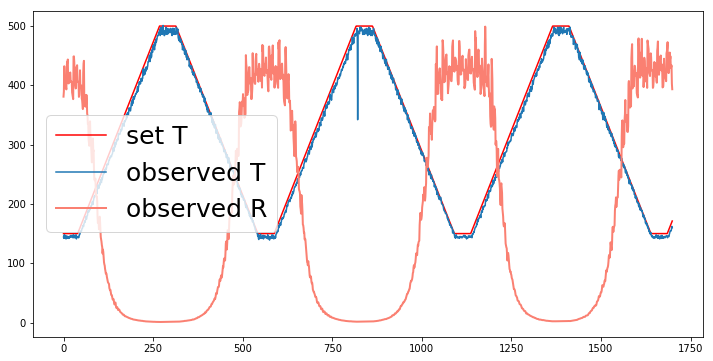

In [28]:
# let's visualize a observed values:
fig, ax = plt.subplots()
ax.plot(np.array(data_file['T_set'][500:2200]), label = 'set T', color='red', linewidth=1.5)
ax.plot(np.array(data_file['T8'][500:2200]), label =  'observed T')
ax.plot(np.array(data_file['R8'][500:2200])/50000, label = 'observed R', linewidth=2.0, color='salmon')
ax.legend(fontsize = 25)
fig.set_figwidth(12)
fig.set_figheight(6)

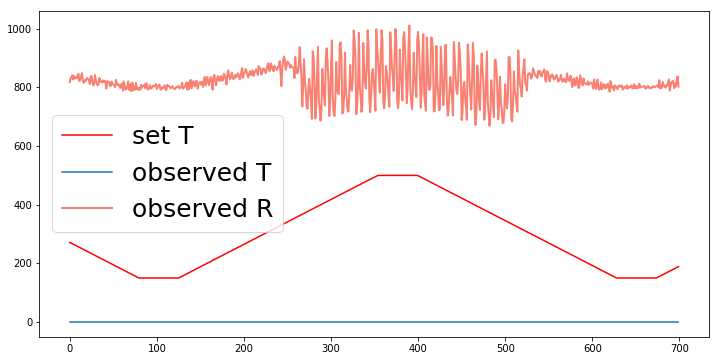

In [63]:
# let's visualize a broken data for sensor 2 (no values for T2 and high noise level of resistence)

fig, ax = plt.subplots()
ax.plot(np.array(data_file['T_set'][111500:112200]), label = 'set T', color='red', linewidth=1.5)
ax.plot(np.array(data_file['T2'][111500:112200]), label =  'observed T')
ax.plot(np.array(data_file['R2'][111500:112200])/100000, label = 'observed R', linewidth=2.0, color='salmon')
ax.legend(fontsize = 25)
fig.set_figwidth(12)
fig.set_figheight(6)

## 2. Prepare data: cut all observations

Goal - create dataset of full 50sec cycles\periods with corresponding values of gas concentrations.

You could find examples of such files in root folder `./cut_experiment2` for sensor **R3**.

There are 2 files for sensor R3:

* file with gas concentrations: *cut_R3_dataY.csv* :

|  | file_num | Stage Num | ObservId_local | CO | H2 |
| :- | :- | :- | :- | :- | :- |
| 3200 | 6.0 | 5.0 | 11.0 | 21.333333 | 0.0 |
| 3201 | 6.0 | 5.0 | 12.0 | 21.333333 | 0.0 |
| 3202 | 6.0 | 5.0 | 13.0 | 21.333333 | 0.0 |
| 3203 | 6.0 | 5.0 | 14.0 | 21.333333 | 0.0 |

> Columns description:
- ` ` - empty column with row numbers of this file;
- `file_num` - id of data file (the sequence number of the data file in the sorted list of filenames);
- `Stage Num` - the same as in raw data (see part 1);
- `ObservId_local` - the same as in raw data (see part 1);
- `CO` & `H2` - columns with concentration of gases (ppm).


* file with sensor responses: *cut_R3_dataX.csv* :
    
|  | 0 | 1 | 2 | 3 | 4 | ... | 500 | 501 | 502 | 503 |
| :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- |
| 3200 | 334558.3 | 338764.9 | 339763.3 | 346024.1 | 317497.5 | ... | 356527.5 | 323535.2 | 295557.8 | 346714.8 |
| 3201 | 334885.1 | 348876.9 | 338944.7 | 339065.6 | 333527.1 | ... | 346309.7 | 306458.4 | 294092.5 | 185230.1 |
| 3202 | 331846.0 | 334781.5 | 339560.2 | 331811.2 | 316959.0 | ... | 312375.3 | 339492.9 | 340384.0 | 392030.5 |
| 3203 | 333107.7 | 336391.6 | 354144.1 | 334263.2 | 273902.3 | ... | 283107.3 | 340617.3 | 376603.9 | 384202.3 |

> Columns description:
- ` ` - empty column with a row numbers of this file;
- `0`, `1`, `2` and etc. - just a column numbers of this file.

In [170]:
# function to convert original time series of observations to 2D array

def get_stage_data(input_data, input_config, stage_num=5, skip_row=5, sensor='R3', target_gases = ['CO', 'H2']):
    
    # get info about gases and concentations from config
    gas_tmp, conc_tmp = [[i['Gas List'], i['Gas Concentrations, ppm']] for i in input_config if i['Stage Num']==stage_num][0]
    
    # save values of concentrations only for target_gases
    out_ppm = np.zeros(len(target_gases))
    for gas_num in range(len(target_gases)):
        if target_gases[gas_num] in gas_tmp:            
            out_ppm[gas_num] = conc_tmp[np.argmax(np.array(gas_tmp)==target_gases[gas_num])]
    out_ppm = [stage_num, 0] + list(out_ppm)
    
    # load subset for selected stage
    tmp_df = input_data.loc[(input_data.Stage==stage_num)&(input_data.ObservId_local>=skip_row)]
    
    if tmp_df.shape[0]>0:
        
    
        out_data = []
        # extract all succesive 50s cycles of measurements and create 2D-array (rows - samples, columns - features)
        for local_id in range(skip_row, int(np.max(tmp_df.ObservId_local))):
            tmp_df_local = tmp_df.loc[tmp_df.ObservId_local==local_id][['Phase', sensor]].reset_index(drop=True)
            #last_index = tmp_df_local.loc[tmp_df_local.Phase!=0].index[-1]
            out_data.append(np.array(tmp_df_local[sensor][:505])) #use last index if no info about max_sample_len

        # create 2D-array of concentrations with row-number same to sensor responses array
        out_y = np.array([out_ppm for i in range(len(out_data))])
        
        if len(out_y)==0: return [], []
        
        out_y[:,1] = np.arange(skip_row, int(np.max(tmp_df.ObservId_local)))
    
        return np.array(out_data), out_y
    
    else:
        return [], []

In [233]:
PATH2RAW = './experiment_2' # path to folder with session_*_data.csv\session_*_config.json
PATH2OUT = '.' # path to output folders 
SENSOR = 'R3' # sensor of interest
SKIP_ROW = 5 # number of skipped rows when new stage of session started
TARGET_GASES = ['CO', 'H2'] # all other gases would be ignored douring samples processing

# get list of names of config files
config_files = np.sort([i for i in os.listdir(PATH2RAW) if i[-4:]=='json'])

global_X, global_Y = [], []

for file_index in range(len(config_files)):
    
    sample_file = config_files[file_index]
    
    # read selected config file
    with open(os.path.join(PATH2RAW, sample_file), 'r') as f:
        loaded_config = json.load(f)
        f.close()
    
    # get only long stages (longer than 60 sec)
    stages_of_interes = [i['Stage Num'] for i in loaded_config if i['Stage Duration, sec']>60]
    

    
    # read data file for corresponding config file 
    raw_data = pd.read_csv(os.path.join(PATH2RAW, sample_file.replace('_config.json', '_data.csv')), index_col=0)

    # process data file stage by stage
    X_data,Y_data = [], []
    for stage_num in stages_of_interes:
        tmp_x, tmp_y = get_stage_data(raw_data, loaded_config, stage_num, skip_row=SKIP_ROW, sensor=SENSOR, target_gases=TARGET_GASES)
        if len(tmp_y)>0:
            X_data.append(tmp_x), Y_data.append(tmp_y)       
    Y_data = np.vstack(Y_data)
    # add info about config_file to Y-file (file with concentrations)
    Y_data = np.hstack([np.reshape(np.ones(Y_data.shape[0])*file_index, [-1, 1]), Y_data])
    # add processed datasets to global list of datasets
    global_X.append(np.vstack(X_data)), global_Y.append(Y_data)

# merge datasets of all sessions to 2D-arrays
global_X = np.vstack(global_X)
global_Y = np.vstack(global_Y)

Found 10 broken samples of 21642 length dataset


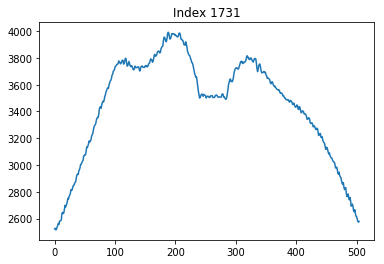

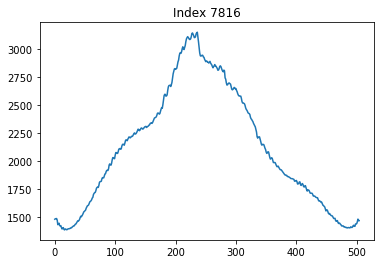

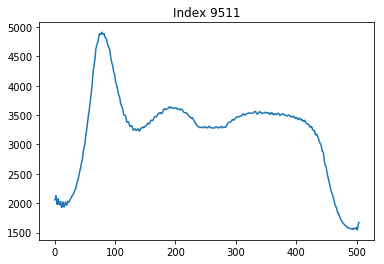

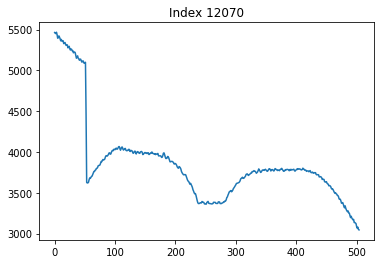

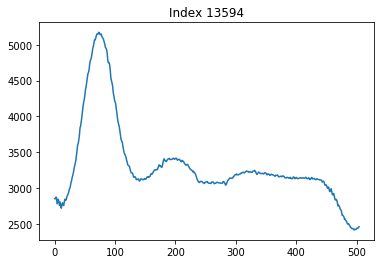

In [245]:
# let's check broken sample.

# idea: if sensor response doesn't change during 50s-cycle - broken sample 
# hint: sometimes some part of sample may be broken. 
#       set threshold value BAD_REC as acceptable number
#       of constant sensor responces within one sample 

BAD_REC = 6
bad_x_indexes = np.where(np.sum(np.diff(global_X, axis=1)==0, axis=1)>BAD_REC)[0]

print("Found", len(bad_x_indexes), "broken samples of", global_X.shape[0],"length dataset")

# let's explore our bad sample:
if len(bad_x_indexes)>0:

    for b_index in bad_x_indexes[:5]:
        plt.plot(global_X[b_index])
        plt.title('Index %s'%b_index)
        plt.show()

In [252]:
# plots above shows strange shape of some samples =>
#     let's drop all `bad` samples!
if len(bad_x_indexes)>0:
    global_X = np.delete(global_X, bad_x_indexes, axis=0)
    global_Y = np.delete(global_Y, bad_x_indexes, axis=0)

In [253]:
#create out folder
if PATH2OUT!='.':
    os.makedirs(PATH2OUT, exist_ok=True)

# record X (sensor response) and Y (stage num, local sample num, gas concentrations) data files
pd.DataFrame(global_X).to_csv(os.path.join(PATH2OUT, 'cut_{sensor}_dataX.csv'.format(sensor=SENSOR)))
pd.DataFrame(global_Y, columns = ['file_num', 'Stage Num', 'ObservId_local']+TARGET_GASES).to_csv(os.path.join(PATH2OUT, 'cut_{sensor}_dataY.csv'.format(sensor=SENSOR)))

In [273]:
# explore recorded data
loaded_outX = pd.read_csv(os.path.join(PATH2OUT, 'cut_{sensor}_dataX.csv'.format(sensor=SENSOR)),index_col=0)
loaded_outY = pd.read_csv(os.path.join(PATH2OUT, 'cut_{sensor}_dataY.csv'.format(sensor=SENSOR)),index_col=0)

loaded_outY.iloc[3200:3205,:]

,file_num,Stage Num,ObservId_local,CO,H2
3200,6.0,5.0,11.0,21.333333,0.0
3201,6.0,5.0,12.0,21.333333,0.0
3202,6.0,5.0,13.0,21.333333,0.0
3203,6.0,5.0,14.0,21.333333,0.0
3204,6.0,5.0,15.0,21.333333,0.0


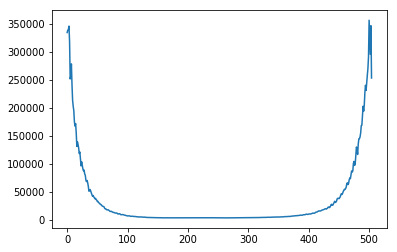

In [261]:
plt.plot(np.array(loaded_outX.loc[3200,:]))